# Scientific Machine Learning

The main objective is to complete a physical model with a data-driven model.

Next work is inspired from those both next articles :  
- 2020, R. G. Nascimento, K. Fricke, F. A. C. Viana, "A tutorial on solving ordinary differential equations using Python and hybrid physics-informed neural network," Engineering Applications of Artificial Intelligence, Vol. 96, 2020, 103996. (DOI: 10.1016/j.engappai.2020.103996).
- 2020, "Augmenting Physical Models with Deep Networks for Complex Dynamics Forecasting", Vincent Le Guen (EDF)...

To Read :
- "Hybrid data-driven physics model-based framework for enhance cyber-physical smart grid security"
- Raissi, Maziar, Paris Perdikaris, and George Em Karniadakis. "Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differential Equations." arXiv preprint arXiv:1711.10561 (2017).
- Raissi, Maziar, Paris Perdikaris, and George Em Karniadakis. "Physics Informed Deep Learning (Part II): Data-driven Discovery of Nonlinear Partial Differential Equations." arXiv preprint arXiv:1711.10566 (2017).


# Import packages

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
from IPython.display import HTML

In [2]:
rng = np.random.RandomState(200)

# Damped Pendulum

The goal is to predict the pendulum position with an imperfect knowledge of the physical equation of the *damped pendulum* equation

\usepackage[makeroom]{cancel}  
The physical equation of the dampend pendulum equation is:
$$\frac{d^2\Theta}{dt^2} + \omega^2sin(\Theta)+ \alpha \frac{d\Theta}{dt} = u(t)$$

We are trying to solve the problem without the $\alpha$ parameter :

$$\frac{d^2\Theta}{dt^2} + \omega^2sin(\Theta)+ {\color{red}\alpha}\frac{d\Theta}{dt} = u(t)$$

Description of the equation :
- $\omega$ is the proper pulsation of the pendulum
- $\alpha$ is the damped parameter. We consider $\alpha$ unknown
- $u(t)$ is the external input 

## Data Generation 
- **T**: period => $\omega = \frac{2\pi}{T}$
- **$\alpha$**: damping coefficient
- **plot_pendulum_animation**: plot pendulum animation (can be long)

Select your input data parameters :
- **dt**: time step duration 
- **time_duration**: total time window with the same timu unit than *dt*
- **t_init**: time step at the beggining of your dataset
- **add_white_gaussian**: add white gaussian noise, tuple(\mu, \sigma)

In [3]:
from input_generation.damped_pendulum import OdePendulum, DampedPendulumDataGeneration
from draw.draw_damped_pendulum import DrawFrame

In [4]:
plot_pendulum_animation = True

In [5]:
L = 36
T = 12.
omega = 2*np.pi / T
alpha = 0.2
dt = 0.5
time_duration = 40
t_init = 0
add_white_gaussian = (0, 0.00)
u = np.zeros(int(time_duration / dt))

In [7]:
ode_pend = OdePendulum(u, time_duration, dt, t_init, omega, alpha)

In [8]:
damp_pendulum = DampedPendulumDataGeneration(solver=ode_pend, initial_state_number=1, 
                                             time_duration=time_duration, dt=dt, t_init=t_init, 
                                             rng=rng, add_white_gaussian=add_white_gaussian)

Initial condition 1:
- *$\Theta(t=0)$* : $\frac{\pi}{2}$
- *$\frac{d\Theta}{dt}(t=0)$*: 0

In [9]:
theta = np.pi / 2
dtheta_dt = 0  # 1.0578833
initial_condition = [theta, dtheta_dt]

In [10]:
res_sim1 = damp_pendulum.add_one_case(initial_condition)

In [11]:
draw_pendulum = DrawFrame(res_sim1[:, 0], L=L, t=damp_pendulum.t)

In [12]:
if plot_pendulum_animation:
    fig, ax, pt, line = draw_pendulum.init_graph()
    anim = draw_pendulum.get_anim(fig, interval=200, blit=False)
    html = HTML(anim.to_html5_video())
    a = display(html)
    plt.close()

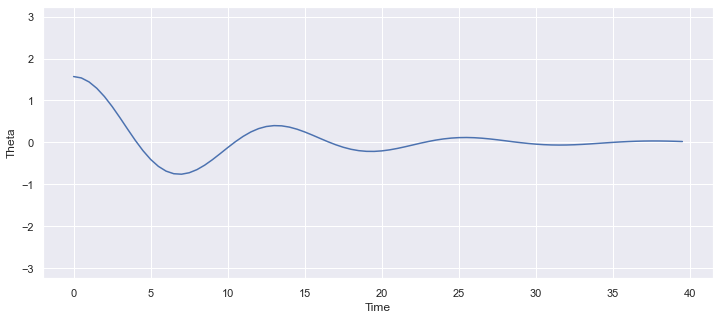

In [13]:
draw_pendulum.plot_theta()

## Resolution

In [14]:
from model import create_model, RMSprop

In a case **you don't know the damped parameter** (alpha), you can try to estimate the *real* alpha:
- **new_alpha, $\alpha_{wrong}$**: a false damped parameter
- **ub**, **lb**: upper and lower bound in order to help the optimization

In [15]:
utrain = u[np.newaxis, :, np.newaxis].astype(np.float32)  # add two axis in order to use tensorflow (batch, time step, numbre of input)
tetha_train = res_sim1[:, 0][np.newaxis, :, np.newaxis]
ub, lb = None, None
initial_condition_tf = np.array(initial_condition).astype(np.float32)[np.newaxis, :]
new_alpha = 0.05
new_alpha_tf = np.array([new_alpha], dtype='float32')  # initial guess, true value is 0.2
omega_tf = np.array([omega], dtype='float32')

In [16]:
model = create_model(omega_tf, new_alpha_tf, dt, initial_state=initial_condition_tf, ub=ub, lb=lb, 
                     batch_input_shape=utrain.shape, optimizer=None)

In [17]:
y_pred_before = model.predict_on_batch(utrain)[0, :, :]

In [18]:
historic = model.fit(utrain, tetha_train, epochs=200, steps_per_epoch=1, verbose=1)

Epoch 1/200
1/1 [==============================] - 3s 3s/step - loss: 0.2120 - mae: 0.4149
Epoch 2/200
1/1 [==============================] - 0s 16ms/step - loss: 0.2064 - mae: 0.4094
Epoch 3/200
1/1 [==============================] - 0s 31ms/step - loss: 0.2011 - mae: 0.4039
Epoch 4/200
1/1 [==============================] - 0s 22ms/step - loss: 0.1959 - mae: 0.3985
Epoch 5/200
1/1 [==============================] - 0s 31ms/step - loss: 0.1909 - mae: 0.3931
Epoch 6/200
1/1 [==============================] - 0s 16ms/step - loss: 0.1860 - mae: 0.3879
Epoch 7/200
1/1 [==============================] - 0s 22ms/step - loss: 0.1812 - mae: 0.3828
Epoch 8/200
1/1 [==============================] - 0s 47ms/step - loss: 0.1766 - mae: 0.3776
Epoch 9/200
1/1 [==============================] - 0s 47ms/step - loss: 0.1721 - mae: 0.3728
Epoch 10/200
1/1 [==============================] - 0s 31ms/step - loss: 0.1678 - mae: 0.3679
Epoch 11/200
1/1 [==============================] - 0s 31ms/step - loss

In [19]:
y_pred = model.predict_on_batch(utrain)[0, :, :]

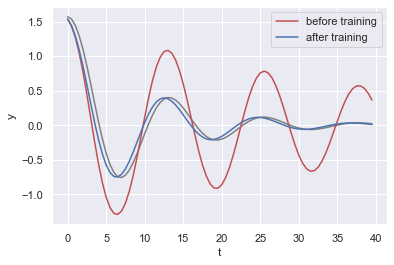

In [20]:
plt.plot(damp_pendulum.t, tetha_train[0, :, :], 'gray')
plt.plot(damp_pendulum.t, y_pred_before[:, :], 'r', label='before training')
plt.plot(damp_pendulum.t, y_pred[:, :], 'b', label='after training')
plt.xlabel('t')
plt.ylabel('y')
plt.grid('on')
plt.legend()
plt.show()

In [21]:
res_sim_with_prev = np.concatenate([res_sim1[:, [0]], y_pred_before, y_pred], axis=1)

In [22]:
prev_draw_pendulum = DrawFrame(res_sim_with_prev, L=L, t=damp_pendulum.t)
legend_name = ["reality", "prev_before", "prev_after"]
if plot_pendulum_animation:
#     fig, ax, pt, line = prev_draw_pendulum.init_graph()
    fig = prev_draw_pendulum.init_graph_multi(legend=legend_name)
    anim = prev_draw_pendulum.get_anim(fig, interval=200, blit=True, multi=True)
    html = HTML(anim.to_html5_video())
    a = display(html)
    plt.close()

## Plot learning improvement

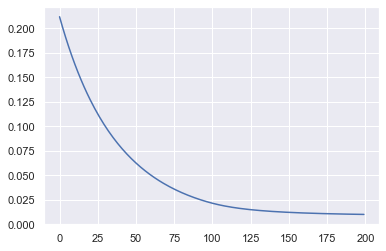

In [23]:
ax = plt.plot(historic.history["loss"])

## Test with white gaussian 
We add a white gaussian noise : $N(\mu, \sigma)$, with $\mu =0,\ \sigma = 1$

In [52]:
L = 36
T = 12.
omega = 2*np.pi / T
alpha = 0.2
dt = 0.025
time_duration = 40
t_init = 0
add_white_gaussian = (0, 1)
u = np.zeros(int(time_duration / dt))

In [53]:
damp_pendulum_test = DampedPendulumDataGeneration(solver=ode_pend, initial_state_number=1, 
                                             time_duration=time_duration, dt=dt, t_init=t_init, 
                                             rng=rng, add_white_gaussian=add_white_gaussian)

### Initial condition

In [54]:
theta = np.pi / 2
dtheta_dt = 0  # 1.0578833
initial_condition = [theta, dtheta_dt]

In [55]:
res_sim_with_wg = damp_pendulum_test.add_one_case(initial_condition)

In [56]:
utrain = u[np.newaxis, :, np.newaxis].astype(np.float32)  # add two axis in order to use tensorflow (batch, time step, numbre of input)
tetha_train = res_sim_with_wg[:, 0][np.newaxis, :, np.newaxis]
ub, lb = None, None
initial_condition_tf = np.array(initial_condition).astype(np.float32)[np.newaxis, :]
new_alpha = 0.05
new_alpha_tf = np.array([new_alpha], dtype='float32')  # initial guess, true value is 0.2
omega_tf = np.array([omega], dtype='float32')

In [57]:
model_wg = create_model(omega_tf, new_alpha_tf, dt, initial_state=initial_condition_tf, ub=ub, lb=lb, 
                        batch_input_shape=utrain.shape, optimizer=None)

In [58]:
y_pred_before_wg = model_wg.predict_on_batch(utrain)[0, :, :]
historic_wg = model_wg.fit(utrain, tetha_train, epochs=200, steps_per_epoch=1, verbose=1)
y_pred_wg = model_wg.predict_on_batch(utrain)[0, :, :]

Epoch 1/200
1/1 [==============================] - 3s 3s/step - loss: 1.1799 - mae: 0.8637
Epoch 2/200
1/1 [==============================] - 1s 517ms/step - loss: 1.1744 - mae: 0.8618
Epoch 3/200
1/1 [==============================] - 0s 482ms/step - loss: 1.1691 - mae: 0.8600
Epoch 4/200
1/1 [==============================] - 0s 499ms/step - loss: 1.1639 - mae: 0.8582
Epoch 5/200
1/1 [==============================] - 0s 488ms/step - loss: 1.1589 - mae: 0.8564
Epoch 6/200
1/1 [==============================] - 1s 519ms/step - loss: 1.1540 - mae: 0.8547
Epoch 7/200
1/1 [==============================] - 0s 498ms/step - loss: 1.1492 - mae: 0.8530
Epoch 8/200
1/1 [==============================] - 1s 501ms/step - loss: 1.1446 - mae: 0.8514
Epoch 9/200
1/1 [==============================] - 0s 486ms/step - loss: 1.1401 - mae: 0.8498
Epoch 10/200
1/1 [==============================] - 1s 517ms/step - loss: 1.1357 - mae: 0.8483
Epoch 11/200
1/1 [==============================] - 1s 517ms/s

### Plot results

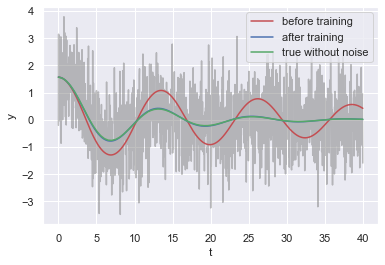

In [59]:
plt.plot(damp_pendulum_test.t, tetha_train[0, :, 0], 'gray', alpha=0.5)
plt.plot(damp_pendulum_test.t, y_pred_before_wg[:, :], 'r', label='before training')
plt.plot(damp_pendulum_test.t, y_pred_wg[:, :], 'b', label='after training')
plt.plot(damp_pendulum_test.t, np.interp(damp_pendulum_test.t, damp_pendulum.t, res_sim1[:, 0]), 'g', label='true without noise')
plt.xlabel('t')
plt.ylabel('y')
plt.grid('on')
plt.legend()
plt.show()

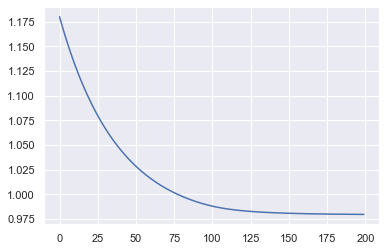

In [60]:
ax = plt.plot(historic_wg.history["loss"])

In [61]:
y_true = np.interp(damp_pendulum_test.t, damp_pendulum.t, res_sim1[:, 0])
y_pred_without_noise = np.interp(damp_pendulum_test.t, damp_pendulum.t, y_pred[:, 0]) 
y_pred_with_noise = y_pred_wg
print(
f"RMSE wihtout noise : {np.sqrt(mean_squared_error(y_true, y_pred_without_noise)):.3f}" + os.linesep + 
f"RMSE with noise    : {np.sqrt(mean_squared_error(y_true, y_pred_with_noise)):.3f}"
)

RMSE wihtout noise : 0.100
RMSE with noise    : 0.014


## With an external input

Chose a time step with an input of 0.5N

In [62]:
L = 36
T = 12.
omega = 2*np.pi / T
alpha = 0.2
dt = 0.025
time_duration = 40
t_init = 0
add_white_gaussian = (0, 0)
new_u = np.zeros(int(time_duration / dt))

In [63]:
t_with_external = int(new_u.shape[0] / 2)
new_u[t_with_external:int(t_with_external + dt * 1000)] = 1

Text(0.5, 1.0, 'External input')

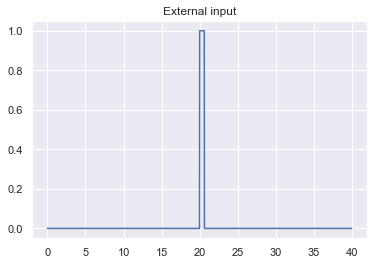

In [64]:
ax, = plt.plot(np.linspace(0, time_duration, new_u.shape[0]), new_u)
plt.title("External input")

In [65]:
ode_pend_ext = OdePendulum(new_u,  time_duration, dt, t_init, omega, alpha)

In [66]:
damp_pendulum_external = DampedPendulumDataGeneration(solver=ode_pend_ext, initial_state_number=1, 
                                             time_duration=time_duration, dt=dt, t_init=t_init, 
                                             rng=rng, add_white_gaussian=None)

In [67]:
res_sim_exter = damp_pendulum_external.add_one_case(initial_condition)

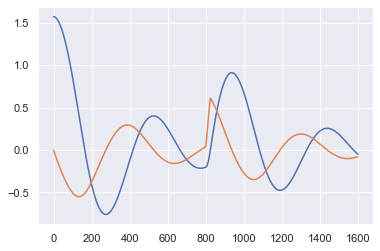

In [68]:
plt.plot(res_sim_exter)

In [69]:
new_utrain = new_u[np.newaxis, :, np.newaxis].astype(np.float32)  # add two axis in order to use tensorflow (batch, time step, numbre of input)
tetha_train = res_sim_exter[:, 0][np.newaxis, :, np.newaxis]
ub, lb = None, None
initial_condition_tf = np.array(initial_condition).astype(np.float32)[np.newaxis, :]
new_alpha = 0.05
new_alpha_tf = np.array([new_alpha], dtype='float32')  # initial guess, true value is 0.2
omega_tf = np.array([omega], dtype='float32')

In [70]:
model_ext = create_model(omega_tf, new_alpha_tf, dt, initial_state=initial_condition_tf, ub=ub, lb=lb, 
                        batch_input_shape=new_utrain.shape, optimizer=None)

In [71]:
y_pred_before_ext = model_ext.predict_on_batch(new_utrain)[0, :, :]
historic_ext = model_ext.fit(new_utrain, tetha_train, epochs=200, steps_per_epoch=1, verbose=1)
y_pred_ext = model_ext.predict_on_batch(new_utrain)[0, :, :]

Epoch 1/200
1/1 [==============================] - 5s 5s/step - loss: 0.3569 - mae: 0.5095
Epoch 2/200
1/1 [==============================] - 1s 718ms/step - loss: 0.3483 - mae: 0.5036
Epoch 3/200
1/1 [==============================] - 1s 781ms/step - loss: 0.3399 - mae: 0.4977
Epoch 4/200
1/1 [==============================] - 1s 639ms/step - loss: 0.3317 - mae: 0.4918
Epoch 5/200
1/1 [==============================] - 1s 651ms/step - loss: 0.3236 - mae: 0.4860
Epoch 6/200
1/1 [==============================] - 1s 649ms/step - loss: 0.3156 - mae: 0.4802
Epoch 7/200
1/1 [==============================] - 1s 640ms/step - loss: 0.3078 - mae: 0.4744
Epoch 8/200
1/1 [==============================] - 1s 577ms/step - loss: 0.3002 - mae: 0.4687
Epoch 9/200
1/1 [==============================] - 1s 637ms/step - loss: 0.2927 - mae: 0.4630
Epoch 10/200
1/1 [==============================] - 1s 646ms/step - loss: 0.2854 - mae: 0.4573
Epoch 11/200
1/1 [==============================] - 1s 605ms/s

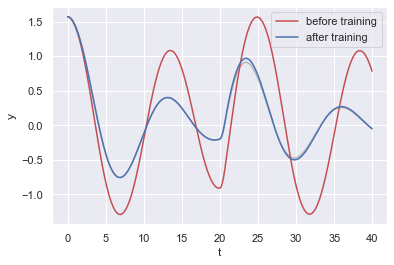

In [74]:
plt.plot(damp_pendulum_external.t, tetha_train[0, :, 0], 'gray', alpha=0.5)
plt.plot(damp_pendulum_external.t, y_pred_before_ext[:, :], 'r', label='before training')
plt.plot(damp_pendulum_external.t, y_pred_ext[:, :], 'b', label='after training')
plt.xlabel('t')
plt.ylabel('y')
plt.grid('on')
plt.legend()
plt.show()

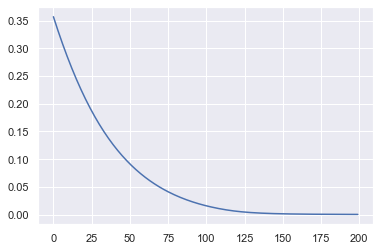

In [75]:
ax = plt.plot(historic_ext.history["loss"])

## Test with different input vector

### Test with no external input **with** the model fitted with an external input

In [76]:
y_pred_with_mod_fit_ext = model_ext.predict_on_batch(utrain)[0, :, :]

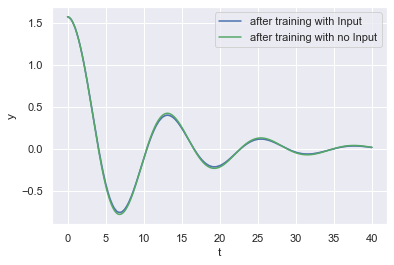

In [192]:
plt.plot(damp_pendulum_test.t, np.interp(damp_pendulum_test.t, damp_pendulum.t, res_sim1[:, 0]), 'gray', alpha=0.5)
plt.plot(damp_pendulum_test.t, y_pred_with_mod_fit_ext[:, :], 'b', label='after training with Input')
plt.plot(damp_pendulum_test.t, y_pred_wg[:, :], 'g', label='after training with no Input')
plt.xlabel('t')
plt.ylabel('y')
plt.grid('on')
plt.legend()
plt.show()

In [193]:
y_true = np.interp(damp_pendulum_test.t, damp_pendulum.t, res_sim1[:, 0])
y_pred_from_with_input_fit = y_pred_with_mod_fit_ext
y_pred_from_no_input_fit = y_pred_wg
print(
f"RMSE from model fitted with an input not null : {np.sqrt(mean_squared_error(y_true, y_pred_from_with_input_fit)):.3f}" + os.linesep + 
f"RMSE from model fitted with an input null     : {np.sqrt(mean_squared_error(y_true, y_pred_from_no_input_fit)):.3f}"
)

RMSE from model fitted with an input not null : 0.004
RMSE from model fitted with an input null     : 0.014


# Comparison with other model

## Classical RNN with LSTM on clean data
Making a classic RNN and compare results with physical informed model.  
Source : "https://www.tensorflow.org/tutorials/structured_data/time_series#recurrent_neural_network"

![title](img/RNN_LSTM_return_equence_True.png)

In [144]:
from time_series_forecast.windows_ts import WindowGenerator, compile_and_fit

Re-use the data with an external input to train other model

<AxesSubplot:>

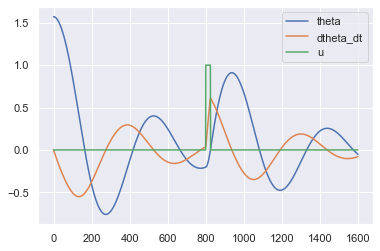

In [145]:
df_train = pd.DataFrame(res_sim_exter, columns=["theta", "dtheta_dt"])
df_train.loc[:, "u"] = new_u
df_train.plot()

In [146]:
df_train_val = df_train.copy()
df_test = df_train.copy()
df_test.loc[:, "theta"] = np.interp(damp_pendulum_test.t, damp_pendulum.t, res_sim1[:, 0])
df_test.loc[:, "dtheta_dt"] = np.interp(damp_pendulum_test.t, damp_pendulum.t, res_sim1[:, 1])
df_test.loc[:, "u"] = 0

In [147]:
L = 36
T = 12.
omega = 2*np.pi / T
alpha = 0.2
dt = 0.025
time_duration = 40
t_init = 0
add_white_gaussian = (0, 0)
new_u2 = np.zeros(int(time_duration / dt))
t_with_external2 = int(new_u2.shape[0] / 4)
new_u2[t_with_external2:int(t_with_external2 + dt * 1000)] = 0.5

t_with_external2 = int(new_u2.shape[0] - (new_u2.shape[0] / 4))
new_u2[t_with_external2:int(t_with_external2 + dt * 2000)] = -0.5

In [148]:
ode_pend_test_gen = OdePendulum(new_u2,  time_duration, dt, t_init, omega, alpha)
damp_pendulum_test_final = DampedPendulumDataGeneration(solver=ode_pend_test_gen, initial_state_number=1, 
                                             time_duration=time_duration, dt=dt, t_init=t_init, 
                                             rng=rng, add_white_gaussian=None)
res_sim_test2 = damp_pendulum_test_final.add_one_case(initial_condition)

<AxesSubplot:>

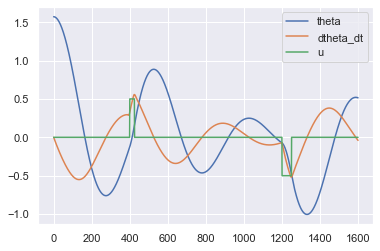

In [149]:
df_test2 = pd.DataFrame(res_sim_test2, columns=["theta", "dtheta_dt"])
df_test2.loc[:, "u"] = new_u2
df_test2.plot()

In [155]:
single_step_window = WindowGenerator(
    input_width=40, label_width=40, shift=1, 
    train_df=df_train.drop("dtheta_dt", axis=1), val_df=df_train_val.drop("dtheta_dt", axis=1), 
    test_df=df_test.drop("dtheta_dt", axis=1),
    label_columns=['theta'])
single_step_window

Total window size: 41
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
Label column name(s): ['theta']

In [156]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [157]:
history = compile_and_fit(lstm_model, single_step_window)

Epoch 1/20
49/49 [==============================] - 5s 28ms/step - loss: 0.0984 - mean_absolute_error: 0.2083 - val_loss: 0.0297 - val_mean_absolute_error: 0.0940
Epoch 2/20
49/49 [==============================] - 1s 17ms/step - loss: 0.0233 - mean_absolute_error: 0.0753 - val_loss: 0.0191 - val_mean_absolute_error: 0.0633
Epoch 3/20
49/49 [==============================] - 1s 17ms/step - loss: 0.0168 - mean_absolute_error: 0.0577 - val_loss: 0.0150 - val_mean_absolute_error: 0.0529
Epoch 4/20
49/49 [==============================] - 1s 17ms/step - loss: 0.0136 - mean_absolute_error: 0.0496 - val_loss: 0.0123 - val_mean_absolute_error: 0.0459
Epoch 5/20
49/49 [==============================] - 1s 17ms/step - loss: 0.0112 - mean_absolute_error: 0.0430 - val_loss: 0.0103 - val_mean_absolute_error: 0.0402
Epoch 6/20
49/49 [==============================] - 1s 17ms/step - loss: 0.0095 - mean_absolute_error: 0.0381 - val_loss: 0.0087 - val_mean_absolute_error: 0.0360
Epoch 7/20
49/49 [====

In [194]:
y_pred_rnn2 = lstm_model.predict(df_test2.drop("dtheta_dt", axis=1).values[np.newaxis, :, :])
y_pred_sml_test = model_ext.predict_on_batch(df_test_wg.loc[:, "u"].values[np.newaxis, :, np.newaxis].astype(np.float32))[0, :, :]

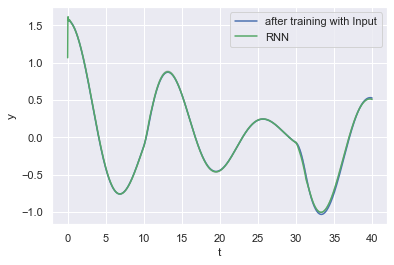

In [195]:
plt.plot(damp_pendulum_test.t, df_test2.loc[:, "theta"], 'gray', alpha=0.5)
plt.plot(damp_pendulum_test.t, y_pred_sml_test[:, :], 'b', label='after training with Input')
plt.plot(damp_pendulum_test.t, y_pred_rnn2[0, :, :], 'g', label='RNN')
plt.xlabel('t')
plt.ylabel('y')
plt.grid('on')
plt.legend()
plt.show()

In [197]:
y_true = df_test2.loc[:, "theta"]
y_pred_rnn2_met = y_pred_rnn2[0, :, :]
y_pred_scientific = y_pred_sml_test
print(
f"RMSE RNN : {np.sqrt(mean_squared_error(y_true, y_pred_rnn2_met)):.3f}" + os.linesep + 
f"RMSE SML : {np.sqrt(mean_squared_error(y_true, y_pred_scientific)):.3f}"
)

RMSE RNN : 0.015
RMSE SML : 0.013


## Classical RNN with LSTM on data with noise
Making a classic RNN and compare results with physical informed model.  

In [165]:
L = 36
T = 12.
omega = 2*np.pi / T
alpha = 0.2
dt = 0.025
time_duration = 40
t_init = 0
add_white_gaussian = (0, 1)
new_u = np.zeros(int(time_duration / dt))
t_with_external = int(new_u.shape[0] / 2)
new_u[t_with_external:int(t_with_external + dt * 1000)] = 1


new_u2 = np.zeros(int(time_duration / dt))
t_with_external2 = int(new_u2.shape[0] / 4)
new_u2[t_with_external2:int(t_with_external2 + dt * 1000)] = 0.5

t_with_external2 = int(new_u2.shape[0] - (new_u2.shape[0] / 4))
new_u2[t_with_external2:int(t_with_external2 + dt * 2000)] = -0.5

In [175]:
ode_pend_train = OdePendulum(new_u,  time_duration, dt, t_init, omega, alpha)
ode_pend_test = OdePendulum(new_u2,  time_duration, dt, t_init, omega, alpha)

damp_pendulum_train_nwg = DampedPendulumDataGeneration(solver=ode_pend_train, initial_state_number=1, 
                                             time_duration=time_duration, dt=dt, t_init=t_init, 
                                             rng=rng, add_white_gaussian=None)
damp_pendulum_train_wg = DampedPendulumDataGeneration(solver=ode_pend_train, initial_state_number=1, 
                                             time_duration=time_duration, dt=dt, t_init=t_init, 
                                             rng=rng, add_white_gaussian=add_white_gaussian)
res_sim_train_nwg = damp_pendulum_train_nwg.add_one_case(initial_condition)
res_sim_train_wg = damp_pendulum_train_wg.add_one_case(initial_condition)

damp_pendulum_test_nwg = DampedPendulumDataGeneration(solver=ode_pend_test, initial_state_number=1, 
                                             time_duration=time_duration, dt=dt, t_init=t_init, 
                                             rng=rng, add_white_gaussian=None)
damp_pendulum_test_wg = DampedPendulumDataGeneration(solver=ode_pend_test, initial_state_number=1, 
                                             time_duration=time_duration, dt=dt, t_init=t_init, 
                                             rng=rng, add_white_gaussian=add_white_gaussian)
res_sim_test_nwg = damp_pendulum_test_nwg.add_one_case(initial_condition)
res_sim_test_wg = damp_pendulum_test_wg.add_one_case(initial_condition)

<AxesSubplot:>

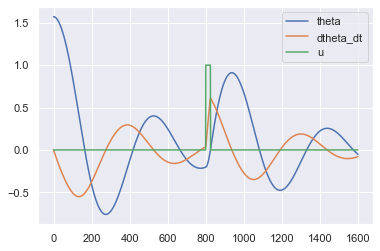

In [168]:
df_train_nwg = pd.DataFrame(res_sim_train_nwg, columns=["theta", "dtheta_dt"])
df_train_nwg.loc[:, "u"] = new_u
df_train_nwg.plot()

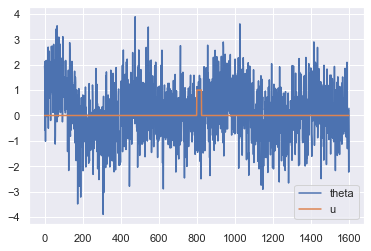

In [198]:
df_train_wg = pd.DataFrame(res_sim_train_wg, columns=["theta", "dtheta_dt"])
df_train_wg.loc[:, "u"] = new_u
df_train_wg.drop("dtheta_dt", axis=1).plot()
df_train_val_wg = df_train_wg.copy()
df_test_wg = df_train_wg.copy()

<AxesSubplot:title={'center':'test'}>

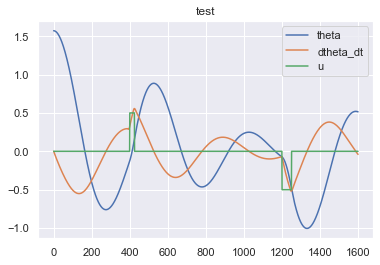

In [181]:
df_test_nwg = pd.DataFrame(res_sim_test_nwg, columns=["theta", "dtheta_dt"])
df_test_nwg.loc[:, "u"] = new_u2
df_test_nwg.plot(title="test")

<AxesSubplot:title={'center':'test'}>

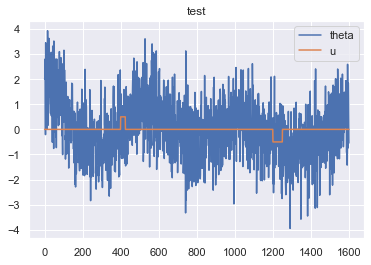

In [200]:
df_test_wg = pd.DataFrame(res_sim_test_wg, columns=["theta", "dtheta_dt"])
df_test_wg.loc[:, "u"] = new_u2
df_test_wg.drop("dtheta_dt", axis=1).plot(title="test")

In [172]:
single_step_window_wg = WindowGenerator(
    input_width=40, label_width=40, shift=1, 
    train_df=df_train_wg.drop("dtheta_dt", axis=1), val_df=df_train_val_wg.drop("dtheta_dt", axis=1), 
    test_df=df_test.drop("dtheta_dt", axis=1),
    label_columns=['theta'])
single_step_window_wg

Total window size: 41
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
Label column name(s): ['theta']

In [173]:
lstm_model_wg = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [174]:
history_wg = compile_and_fit(lstm_model_wg, single_step_window_wg)

Epoch 1/20
49/49 [==============================] - 8s 32ms/step - loss: 1.1337 - mean_absolute_error: 0.8535 - val_loss: 1.0688 - val_mean_absolute_error: 0.8290
Epoch 2/20
49/49 [==============================] - 1s 17ms/step - loss: 1.0663 - mean_absolute_error: 0.8286 - val_loss: 1.0650 - val_mean_absolute_error: 0.8279
Epoch 3/20
49/49 [==============================] - 1s 18ms/step - loss: 1.0645 - mean_absolute_error: 0.8278 - val_loss: 1.0637 - val_mean_absolute_error: 0.8276
Epoch 4/20
49/49 [==============================] - 1s 19ms/step - loss: 1.0634 - mean_absolute_error: 0.8273 - val_loss: 1.0626 - val_mean_absolute_error: 0.8270
Epoch 5/20
49/49 [==============================] - 1s 17ms/step - loss: 1.0621 - mean_absolute_error: 0.8269 - val_loss: 1.0609 - val_mean_absolute_error: 0.8264
Epoch 6/20
49/49 [==============================] - 1s 17ms/step - loss: 1.0606 - mean_absolute_error: 0.8262 - val_loss: 1.0595 - val_mean_absolute_error: 0.8258
Epoch 7/20
49/49 [====

In [183]:
y_pred_rnn_wg = lstm_model_wg.predict(df_test_wg.drop("dtheta_dt", axis=1).values[np.newaxis, :, :])
y_pred_sml_test_wg = model_ext.predict_on_batch(df_test_wg.loc[:, "u"].values[np.newaxis, :, np.newaxis].astype(np.float32))[0, :, :]

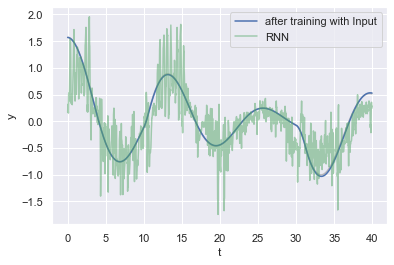

In [187]:
plt.plot(damp_pendulum_test.t, df_test_nwg.loc[:, "theta"], 'gray', alpha=0.5)
plt.plot(damp_pendulum_test.t, y_pred_sml_test_wg[:, :], 'b', label='after training with Input')
plt.plot(damp_pendulum_test.t, y_pred_rnn_wg[0, :, :], 'g', label='RNN', alpha=0.5)
plt.xlabel('t')
plt.ylabel('y')
plt.grid('on')
plt.legend()
plt.show()

In [191]:
y_true = df_test_nwg.loc[:, "theta"]
y_pred_rnn2_met = y_pred_rnn_wg[0, :, :]
y_pred_scientific = y_pred_sml_test_wg[:, :]
print(
f"RMSE RNN : {np.sqrt(mean_squared_error(y_true, y_pred_rnn2_met)):.3f}" + os.linesep + 
f"RMSE SML : {np.sqrt(mean_squared_error(y_true, y_pred_scientific)):.3f}"
)

RMSE RNN : 0.385
RMSE SML : 0.013


# First conclusion

Physical informed 

# TODO

- Depends on initial conditions : do a model which could adapt with different initial conditions
- Case if you don't know the complete version of the physical model :$\frac{d^2\Theta}{dt^2} + \omega^2sin(\Theta)+ {\color{red}\alpha}\frac{d\Theta}{dt} = u(t)$ -> $\frac{d^2\Theta}{dt^2} + \omega^2sin(\Theta)+ {\color{red}{\alpha(t, \Theta)}} = u(t)$
- missing data
- alpha depending on the time $\frac{d^2\Theta}{dt^2} + \omega^2sin(\Theta)+ {\color{red}{\alpha(t)}}\frac{d\Theta}{dt} = u(t)$